# 01_dataset_dataloader.ipynb

This file create Dataset and DataLoader

### you need to install openCV before run this
You can install this from Anaconda GUI or
ex) conda install -c conda-forge opencv

In [5]:
# import package
import os.path as osp
import random
# libraries for reading/editing/storeing XML files
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [6]:
# set random seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [7]:
# create file path list for image and annotation data

def make_datapath_list(rootpath):
    """
    create a file-path list 

    Parameters
    ----------
    rootpath : str
        path for data folder

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        list that stores data path
    """

    # create a template for image and annotation files
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # get file name (id) for training and validataion data
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # create a path-list for image and annotation files on training data
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # remove whitespace and line breaks
        img_path = (imgpath_template % file_id)   # path for image file
        anno_path = (annopath_template % file_id) # path for annotation file
        train_img_list.append(img_path)    # add them to list
        train_anno_list.append(anno_path)  # add them to list

    # create a path-list for image and annotation files on validation data
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  
        img_path = (imgpath_template % file_id)  
        anno_path = (annopath_template % file_id)  
        val_img_list.append(img_path)  
        val_anno_list.append(anno_path)  

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [8]:
# create a file-path list
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# confirmation
print(train_img_list[0])


./data/VOCdevkit/VOC2012/JPEGImages\2008_000008.jpg


In [9]:
# class for converting XML annotations to list format


class Anno_xml2list(object):
    """
    convert XML annotations to list-format per image

    Attributes
    ----------
    classes : list
        a list of VOC class name
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        convert XML annotations to list-format per image

        Parameters
        ----------
        xml_path : str
            path for xml file
        width : int
            width of the image 
        height : int
            height of the image

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            A list containing the annotation data of an object
            with elements for the number of objects present in the image
        """

        # This list will contain the annotations of all objects in the image
        ret = []

        # read xml file
        xml = ET.parse(xml_path).getroot()

        # Looping through the number of objects in the image
        for obj in xml.iter('object'):

            # Exclude those with detection set to 'difficult' in the annotation
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # A list that contains annotations for a single object
            # (bounding box)
            bndbox = []

            name = obj.find('name').text.lower().strip()  # object name
            bbox = obj.find('bndbox')  # name of bounding box

            # get xmin, ymin, xmax, ymax and normalized them into [0,1]
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC has an origin of (1,1), so subtract 1 to (0, 0)
                cur_pixel = int(bbox.find(pt).text) - 1

                # normalizing width and height
                if pt == 'xmin' or pt == 'xmax':  # width (x)
                    cur_pixel /= width
                else:  # height (y)
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # Get the index of the annotation class name and add
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # add [xmin, ymin, xmax, ymax, label_ind] to ret
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [10]:
# confirmation
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# read image with OpenCV
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [height][width][color=BGR]
height, width, channels = img.shape  # get image size

# display annotation in a list
transform_anno(val_anno_list[ind], width, height)


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [11]:
# import from data_augmentation.py in the "utils" folder 
# Class for preprocessing the input image
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    class for preprocessing for image and annotation
    this behaves differently in the training and the test
     (in the training, data augmentation is applied)
    set image size 300x300
    


    Attributes
    ----------
    input_size : int
        size of resized image
    color_mean : (B, G, R) - not R,G,B
        mean color of the image
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # convert int to float32
                ToAbsoluteCoords(),  # Restore normalized annotation data to its original value
                PhotometricDistort(),  # Random modification on hue and saturation 
                Expand(color_mean),  # enlarge image camvas
                RandomSampleCrop(),  # random cropping
                RandomMirror(),  # mirror image
                ToPercentCoords(),  # normalize annotation into [0,1]
                Resize(input_size),  # resize image into input_size×input_size
                SubtractMeans(color_mean)  # subtract mean color (B,G,R)
            ]),
            'val': Compose([
                ConvertFromInts(),  # convert int to float32
                Resize(input_size),  #  resize image into input_size×input_size
                SubtractMeans(color_mean)  # subtract mean color
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            set pre-processing mode
        """
        return self.data_transform[phase](img, boxes, labels)


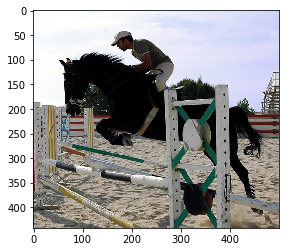

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


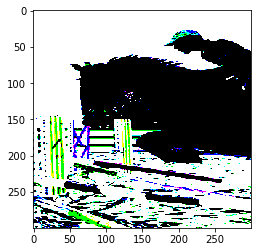

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


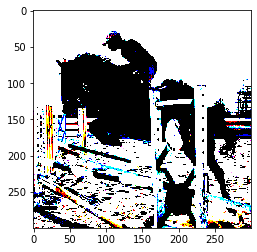

In [12]:
# confirmation

# 1. read image
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [Height][Width][Color=BGR]
height, width, channels = img.shape  # get image size

# 2. store annotation into a list
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. display original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. create pre-processing class
color_mean = (104, 117, 123)  # mean color of (BGR)
input_size = 300  # set size of input 300x300
transform = DataTransform(input_size, color_mean)

# 5. display training image
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. display validation image
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# create Dataset

In [13]:
# create VOC2012 Dataset

class VOCDataset(data.Dataset):
    """
    Class for creating VOC2012 Dataset 
     derived from PyTorch's Dataset class

    Attributes
    ----------
    img_list : list
        A list of image paths
    anno_list : リスト
        A list of annotation
    phase : 'train' or 'inference'
        set train or inference
    transform : object
        instance of pre-processing
    transform_anno : object
        An instance that converts xml annotations to a list
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train or val
        self.transform = transform  # transoform of the image
        self.transform_anno = transform_anno  # convert annotation data from xml to list

    def __len__(self):
        '''return number of images'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        Obtain tensor data and annotations of pre-processed images
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''Obtain tensor data, annotations, image height and width of the pre-processed image'''

        # 1. read images
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [Height][Width][Color=BGR]
        height, width, channels = img.shape  # get image size

        # 2. converting xml annotation information into a list
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. pre-processing
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # Change the order of color channels to BGR and RGB.
        # Convert (height, width, color channel) to (color channel, height, width)
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # Create np.array with BBox and labels (gt: ground truth)
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [14]:
# confirmation
color_mean = (104, 117, 123)  # mean (BGR)
input_size = 300 

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# example of data
val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# Create DataLoader

In [15]:
def od_collate_fn(batch):
    """
    This function helps to create a mini-batch from a list
     (as called from data.DataLoader.collate_fn)

    The number of annotations varies from image to image.
    ex) if there are n annotations in the image, shape of annotation will be (n,5)
      (n, [xmin, ymin, xmax, ymax, label_index])  

    A customized collate_fn is defined to create a DataLoader that accommodates this variability.
    (note: collate_fn creates a mini-batch from a list in PyTorch.)
    
    Transform the list variable ‘batch’ that contains the mini-batch images 
              by adding one dimension that specifies the mini-batch number.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] is a image
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] is gt annotation 

    # 'imgs' is a list of mini-bath size 
    # dimension of each element of this list is torch.Size([3, 300, 300])
    # this converts this list into torch.Size([batch_num, 3, 300, 300])
    imgs = torch.stack(imgs, dim=0)

    # targets is a list of gt annotation
    # size of this list is mini-batch size.
    # dimension of each element of this list is [n, 5]
    # n is different for each image and is the number of objects in the image.
    # 5 is [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets


In [16]:
# create DataLoader

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# store those DataLoaders into dictionary-type variable
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# confirmation
batch_iterator = iter(dataloaders_dict["val"])  # convert data into the iterator
images, targets = next(batch_iterator)  # extract 1st element
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # torch.Size([n, 5]) n: number of annotations


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [13]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823
